# IMPORT DEPENDENCIES

In [1]:
import shap
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.svm import NuSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder
import sklearn.datasets as datasets
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import csv

# SHAP Functions

In [10]:
def choose_explainer(model, X, model_type):
    tree_models = ['rf', 'xgb']
    kernel_models = ['SVC', 'MLP', 'NuSVC']
    if model_type in tree_models:
        return shap.TreeExplainer(model)
    if model_type in kernel_models:
        return shap.KernelExplainer(model.predict_proba, X)

def add_predict_proba_to_df(model, model_type, df, features):
    model_predict = model.predict(df[features])
    model_proba = [proba[1] for proba in model.predict_proba(df[features])]
    df[model_type + '_predict'] = model_predict
    df[model_type + '_proba'] = model_proba
    return df

def add_shap_to_df(model, model_type, df, index_shap=True, features=[]):
    print('Original # of features: ', len(df.columns))
    if index_shap:
        explainer = choose_explainer(model=model, X=df[features], model_type=model_type)
        shap_values = explainer.shap_values(df[features])
        display('Generated SHAP values for model type: ', model_type)
        for feat in features:
            df[feat + '_' + model_type +'_shap'] = [shap_values[1][n][df.columns.get_loc(feat)] for n in range(0, len(df[features]))]
    else: 
        explainer = choose_explainer(model=model, X=df[features], model_type=model_type)
        shap_values = explainer.shap_values(df[features])
        display('Generated SHAP values for model type: ', model_type)
        for feat in features:
            df[feat + '_' + model_type +'_shap'] = [shap_values[n][df.columns.get_loc(feat)] for n in range(0, len(df[features]))]
        
    return df
    print('New # of features: ', len(df.columns))


def add_shap_pred_proba_to_df(model, model_type, df, index_shap=True, features=[]):
    df = add_shap_to_df(model=model, model_type=model_type, df=df, index_shap=index_shap, features=features)
    df = add_predict_proba_to_df(model=model, model_type=model_type, df=df, features=features)
    return df
    
def prepare_csv_data(filepath, y_label, hot_encode_labels=[], features_to_drop=[],  test_size=0.33):
    df = pd.read_csv(filepath)
    
    if not features_to_drop:
        df.drop(columns=features_to_drop)
    
    for label in hot_encode_labels:
        hot_enc = OneHotEncoder(handle_unknown='ignore')
        enc_df = pd.DataFrame(hot_enc.fit_transform(df[[label]]).toarray())
        for col in enc_df.columns:
            enc_df = enc_df.rename(columns={col: '{label}_{col}'.format(label=label, col=col)})
        df = df.join(enc_df)
        df = df.drop(columns=[label])
        print('once')
    
    df = df.dropna()
    
    y = df[y_label].copy()
    df.drop(columns=[y_label])
    X = df.copy()
    return train_test_split(X, y, test_size=test_size, random_state=98)

def train_level_1(stacked_model, X_train, y_train):
    stacked_model['xgb'] = XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=10, max_depth=5).fit(X_train, y_train)
    stacked_model['rf'] = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)
#     stacked_model['SVC'] = SVC(kernel='linear', probability=True).fit(X_train, y_train)
    stacked_model['MLP'] = MLPClassifier(activation = "relu", alpha = 0.1, hidden_layer_sizes = (10,10,10),
                            learning_rate = "constant", max_iter = 2000, random_state = 1000).fit(X_train, y_train)
    stacked_model['NuSVC'] = NuSVC(degree = 1, kernel = "rbf", nu = 0.25, probability = True).fit(X_train, y_train)
    return stacked_model
    

def add_shap_pred_proba_to_level_1(stacked_model, X, y, original_features):
    X = add_shap_pred_proba_to_df(model=stacked_model['xgb'], model_type='xgb', df=X, index_shap=False, features=original_features)
    X = add_shap_pred_proba_to_df(model=stacked_model['rf'], model_type='rf', df=X, index_shap=True, features=original_features)
#     X = add_shap_pred_proba_to_df(model=stacked_model['SVC'], model_type='SVC', df=X, index_shap=True, features=original_features)
    X = add_shap_pred_proba_to_df(model=stacked_model['MLP'], model_type='MLP', df=X, index_shap=True, features=original_features)
    X = add_shap_pred_proba_to_df(model=stacked_model['NuSVC'], model_type='NuSVC', df=X, index_shap=True, features=original_features)
    return X
    

def train_meta_model(stacked_model, X_train, y_train, original_features):
    shap_columns = []
    
    for feat in original_features:
        shap_columns += [feat + '_' + model_type + '_shap' for model_type in stacked_model.keys()]
    
    stacked_model['meta'] = SVC(kernel='linear', probability=True).fit(X_train.drop(columns=shap_columns), y_train)
    
    stacked_model['meta_shap'] = SVC(kernel='linear', probability=True).fit(X_train, y_train)
    
    return stacked_model
    
    
def run_analysis_on_csv_data(filepath, hot_encode_labels, features_to_drop, y_label):
    
    stacked_model = {}
    
    X_train, X_test, y_train, y_test = prepare_csv_data(filepath, hot_encode_labels, features_to_drop, y_label) #Do test_train_split on data from csv file
    
    original_features = X_train.copy().columns
    
    stacked_model = train_level_1(stacked_model, X_train, y_train)
    
    
    

In [11]:
# Dataset 1 link: https://physionet.org/content/mimic2-iaccd/1.0/
filepath = 'Datasets/full_cohort_data.csv'
y_label = 'day_28_flg'
hot_encode_labels = ['day_icu_intime', 'service_unit']
features_to_drop = []

X_train, X_test, y_train, y_test = prepare_csv_data(filepath=filepath, y_label=y_label, hot_encode_labels=hot_encode_labels, features_to_drop=features_to_drop)

display(X_train)

original_features = X_train.copy().columns

stacked_model = {}

stacked_model = train_level_1(stacked_model, X_train, y_train)

X_train = add_shap_pred_proba_to_level_1(stacked_model, X_train, y_train, original_features)

stacked_model = train_meta_model

display(stacked_model)

once
once


,aline_flg,icu_los_day,hospital_los_day,age,gender_num,weight_first,bmi,sapsi_first,sofa_first,service_num,...,day_icu_intime_0,day_icu_intime_1,day_icu_intime_2,day_icu_intime_3,day_icu_intime_4,day_icu_intime_5,day_icu_intime_6,service_unit_0,service_unit_1,service_unit_2
398,0,1.85,2,78.33267,1.0,98.0,29.953233,13.0,7.0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
330,1,1.56,9,88.97058,1.0,63.5,15.394171,16.0,5.0,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
394,1,3.82,9,77.67180,0.0,68.7,26.829230,23.0,8.0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
872,1,1.75,6,22.98131,1.0,96.0,29.924987,10.0,7.0,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
197,1,4.08,10,49.80052,1.0,79.0,28.110708,14.0,9.0,1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,0,1.58,2,34.11278,1.0,73.0,22.325388,11.0,3.0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
917,0,3.83,6,47.30891,1.0,81.0,25.974846,10.0,4.0,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
84,0,1.72,10,43.40327,1.0,79.5,28.723749,14.0,6.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
777,1,3.41,4,77.83247,1.0,72.0,21.448406,15.0,6.0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


Original # of features:  54


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


'Generated SHAP values for model type: '

'xgb'

Original # of features:  110


'Generated SHAP values for model type: '

'rf'

Using 712 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Original # of features:  166


  0%|          | 0/712 [00:00<?, ?it/s]

KeyboardInterrupt: 

# LOAD IN DATA

In [18]:
use_breast_cancer = True

number_of_datasets = 0

if use_breast_cancer:
    breast_cancer_data = datasets.load_breast_cancer(as_frame=True)
    number_of_datasets += 1
    breast_cancer_X_train, breast_cancer_X_test, breast_cancer_y_train, breast_cancer_y_test = train_test_split(breast_cancer_data['data'], breast_cancer_data['target'], test_size=0.33, random_state=42)
    breast_cancer_features = breast_cancer_data['data'].columns
    display(breast_cancer_X_train[breast_cancer_features])
print('Number of datasets used: ', number_of_datasets)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
172,15.460,11.89,102.50,736.9,0.12570,0.15550,0.20320,0.10970,0.1966,0.07069,...,18.790,17.04,125.00,1102.0,0.15310,0.35830,0.58300,0.18270,0.3216,0.10100
407,12.850,21.37,82.63,514.5,0.07551,0.08316,0.06126,0.01867,0.1580,0.06114,...,14.400,27.01,91.63,645.8,0.09402,0.19360,0.18380,0.05601,0.2488,0.08151
56,19.210,18.57,125.50,1152.0,0.10530,0.12670,0.13230,0.08994,0.1917,0.05961,...,26.140,28.14,170.10,2145.0,0.16240,0.35110,0.38790,0.20910,0.3537,0.08294
497,12.470,17.31,80.45,480.1,0.08928,0.07630,0.03609,0.02369,0.1526,0.06046,...,14.060,24.34,92.82,607.3,0.12760,0.25060,0.20280,0.10530,0.3035,0.07661
301,12.460,19.89,80.43,471.3,0.08451,0.10140,0.06830,0.03099,0.1781,0.06249,...,13.460,23.07,88.13,551.3,0.10500,0.21580,0.19040,0.07625,0.2685,0.07764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,8.888,14.64,58.79,244.0,0.09783,0.15310,0.08606,0.02872,0.1902,0.08980,...,9.733,15.67,62.56,284.4,0.12070,0.24360,0.14340,0.04786,0.2254,0.10840
106,11.640,18.33,75.17,412.5,0.11420,0.10170,0.07070,0.03485,0.1801,0.06520,...,13.140,29.26,85.51,521.7,0.16880,0.26600,0.28730,0.12180,0.2806,0.09097
270,14.290,16.82,90.30,632.6,0.06429,0.02675,0.00725,0.00625,0.1508,0.05376,...,14.910,20.65,94.44,684.6,0.08567,0.05036,0.03866,0.03333,0.2458,0.06120
435,13.980,19.62,91.12,599.5,0.10600,0.11330,0.11260,0.06463,0.1669,0.06544,...,17.040,30.80,113.90,869.3,0.16130,0.35680,0.40690,0.18270,0.3179,0.10550


Number of datasets used:  1


# TRAIN STACKED MODELS

In [21]:
if use_breast_cancer:
    breast_cancer = {}
    breast_cancer['xgb'] = XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=10, max_depth=5).fit(breast_cancer_X_train[breast_cancer_features], breast_cancer_y_train)
    breast_cancer['rf'] = RandomForestClassifier(n_estimators=10).fit(breast_cancer_X_train[breast_cancer_features], breast_cancer_y_train)
    
    breast_cancer_X_train = breast_cancer_X_train.assign(predict_xgb=breast_cancer['xgb'].predict(breast_cancer_X_train[breast_cancer_features])).copy()
    breast_cancer_X_train = breast_cancer_X_train.assign(proba_xgb=[prob[1] for prob in breast_cancer['xgb'].predict_proba(breast_cancer_X_train[breast_cancer_features])]).copy()
    breast_cancer_X_train = breast_cancer_X_train.assign(predict_rf=breast_cancer['rf'].predict(breast_cancer_X_train[breast_cancer_features])).copy()
    breast_cancer_X_train = breast_cancer_X_train.assign(proba_rf=[prob[1] for prob in breast_cancer['rf'].predict_proba(breast_cancer_X_train[breast_cancer_features])]).copy()
    
    breast_cancer_X_test = breast_cancer_X_test.assign(predict_xgb=breast_cancer['xgb'].predict(breast_cancer_X_test[breast_cancer_features])).copy()
    breast_cancer_X_test = breast_cancer_X_test.assign(proba_xgb=[prob[1] for prob in breast_cancer['xgb'].predict_proba(breast_cancer_X_test[breast_cancer_features])]).copy()
    breast_cancer_X_test = breast_cancer_X_test.assign(predict_rf=breast_cancer['rf'].predict(breast_cancer_X_test[breast_cancer_features])).copy()
    breast_cancer_X_test = breast_cancer_X_test.assign(proba_rf=[prob[1] for prob in breast_cancer['rf'].predict_proba(breast_cancer_X_test[breast_cancer_features])]).copy()
    
#     display(breast_cancer_X_train)
    
    breast_cancer_X_train_shap = breast_cancer_X_train.copy()
    breast_cancer_X_train_shap = add_shap_to_df(model=breast_cancer['xgb'], model_type='xgb', df=breast_cancer_X_train.copy(), X_train=breast_cancer_X_train.copy(), index_shap=False, all_features=False, features=breast_cancer_features).copy()
    breast_cancer_X_train_shap = add_shap_to_df(model=breast_cancer['rf'], model_type='rf', df=breast_cancer_X_train.copy(), X_train=breast_cancer_X_train.copy(), index_shap=True, all_features=False, features=breast_cancer_features).copy()
    
    breast_cancer_X_test_shap = breast_cancer_X_test.copy()
    breast_cancer_X_test_shap = add_shap_to_df(model=breast_cancer['xgb'], model_type='xgb', df=breast_cancer_X_test.copy(), X_train=breast_cancer_X_train.copy(), index_shap=False, all_features=False, features=breast_cancer_features).copy()
    breast_cancer_X_test_shap = add_shap_to_df(model=breast_cancer['rf'], model_type='rf', df=breast_cancer_X_test.copy(), X_train=breast_cancer_X_train.copy(), index_shap=True, all_features=False, features=breast_cancer_features).copy()
    
#     display(breast_cancer_X_train_shap)
    
    breast_cancer['meta'] = LogisticRegression(max_iter=800).fit(breast_cancer_X_train, breast_cancer_y_train)
    breast_cancer['meta_shap'] = LogisticRegression(max_iter=800).fit(breast_cancer_X_train_shap, breast_cancer_y_train)
    
    display(breast_cancer['meta'].score(breast_cancer_X_test, breast_cancer_y_test))
    display(breast_cancer['meta_shap'].score(breast_cancer_X_test_shap, breast_cancer_y_test))
    
    
#     breast_cancer_meta = breast_cancer_meta.fit(breast_cancer_X_train, breast_cancer_y_train)
#     display(breast_cancer_meta.score(breast_cancer_X_test, breast_cancer_y_test))
#     breat_cancer_meta_shap

Original # of features:  34
Computing SHAP values for first layer...
Generated explainer...
New # of features:  64
Original # of features:  34
Computing SHAP values for first layer...
Generated explainer...



ntree_limit is deprecated, use `iteration_range` or model slicing instead.


New # of features:  64
Original # of features:  34
Computing SHAP values for first layer...
Generated explainer...
New # of features:  64
Original # of features:  34
Computing SHAP values for first layer...
Generated explainer...

New # of features:  64


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


0.9787234042553191

0.9787234042553191

# VALIDATE AGAINST SHAPLEY BOOSTED

In [5]:
if use_breast_cancer:
    print('No shap: ', roc_auc_score(breast_cancer_y_test, breast_cancer['meta'].predict(breast_cancer_X_test)))
    print('With shap: ', roc_auc_score(breast_cancer_y_test, breast_cancer['meta_shap'].predict(breast_cancer_X_test_shap)))

No shap:  0.9925373134328358
With shap:  0.9925373134328358


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


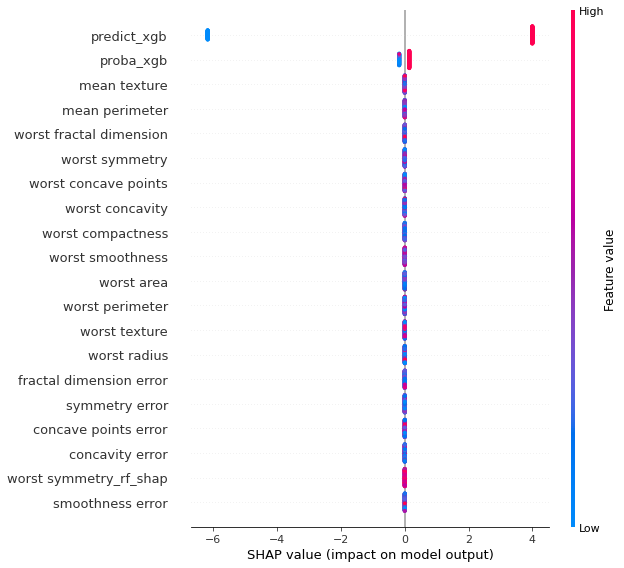

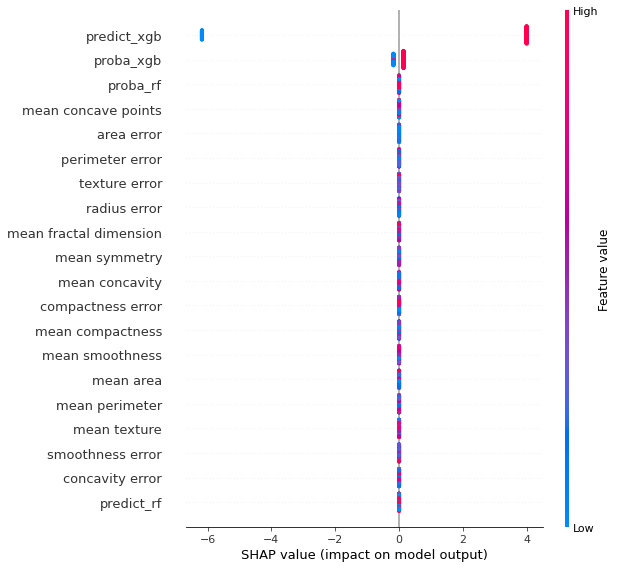

In [16]:
explainer = shap.TreeExplainer(breast_cancer['meta_shap'])
shap_values = explainer.shap_values(breast_cancer_X_test_shap)
shap.summary_plot(shap_values, breast_cancer_X_test_shap)

explainer = shap.TreeExplainer(breast_cancer['meta'])
shap_values = explainer.shap_values(breast_cancer_X_test)
shap.summary_plot(shap_values, breast_cancer_X_test)